# SVM-set A, B, C with train test split

In [17]:
#importing libraries
from modules.pca_module import perform_pca
import numpy as np
import pandas as pd
from numpy import array  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, auc, make_scorer, precision_score, recall_score, fbeta_score,  average_precision_score
from urllib.request import urlretrieve
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os 
import math
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC

In [18]:
SEED = 123
RANDOM_STATE = 42
def seed_everything(seed=SEED):
    """
    Set the random seed for Python, NumPy, and random module.

    Parameters:
    - seed (int): The seed value to set for randomness. Defaults to 42.

    Returns:
    - None
    """
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

In [19]:
#GLOBAL VARIABLES
#define percentage of test_split
test_size = 0.2
# Define the programmer whose path you want to use
programmer = 'ivelize'

#variables for paths names
file_paths_names = {'ivelize': r"C:\Users\migde\OneDrive\Escritorio\DSPT12\COLAB PROJECT\COLAB GITHUB\UCI_prediction_final_project\data\Patients"}

files_outcome_path_names = {'ivelize': r"C:\Users\migde\OneDrive\Escritorio\DSPT12\COLAB PROJECT\COLAB GITHUB\UCI_prediction_final_project\data\outcomes"}

files_path_to_save_files = {'ivelize': r"C:/Users/migde/OneDrive/Escritorio/DSPT12/COLAB PROJECT/COLAB GITHUB/UCI_prediction_final_project/clean_data/withsetc"}

# Choose the file path based on the programmer variable
file_path_to_save = files_path_to_save_files[programmer]
file_path_to_open = file_path_to_save



### 1. Look at the distribution of the target variable

In [20]:
#loading dataframe for plottin distirbution
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [21]:
# counting positive and negative samples
knn_df['In-hospital_death'].value_counts()
num_pos_samples = knn_df['In-hospital_death'].value_counts()[1]
num_neg_samples  = knn_df['In-hospital_death'].value_counts()[0]
print("Number of positive samples for in hospital death:", num_pos_samples)
print("Number of negative samples for in hospital death:", num_neg_samples)

Number of positive samples for in hospital death: 1707
Number of negative samples for in hospital death: 10293


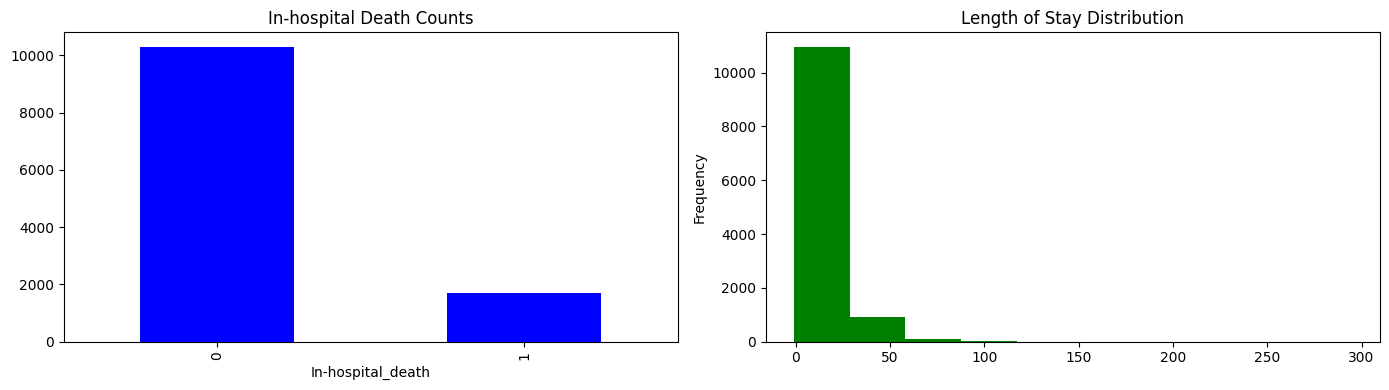

In [22]:
# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()

## 2. SVM Modelling - In Hospital death prediction


In [23]:
def perform_svm_grid_search(X_train, y_train, svm_param_grid, scorer, method_name, cross_validation_folds=5):
    """
    Perform grid search with Support Vector Machine classifier to find the best parameter combination.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    svm_param_grid (dict): Grid of parameters for SVM classifier.
    scorer (callable): Scoring function for evaluation.
    cross_validation_folds (int): Number of cross-validation folds (default is 5).

    Returns:
    results_df (DataFrame): DataFrame containing results of the grid search.
    best_params (dict): Best parameters found during grid search.
    """

    # Create SVM classifier instance
    svm_classifier = SVC()

    # Create a KFold cross-validator
    kf = KFold(n_splits=cross_validation_folds, shuffle=True)

    # Create grid search to find the best parameter combination
    svm_grid_search = GridSearchCV(estimator = svm_classifier,
                                   param_grid = svm_param_grid,
                                   cv = kf,
                                   scoring = scorer,
                                   verbose = 1)

    # Fit all the parameter combinations to train data using cross-validation
    svm_grid_search.fit(X_train, y_train)

    # Get the best parameters found during grid search
    best_params = svm_grid_search.best_params_

    # Convert cv_results_ to a DataFrame
    results_df = pd.DataFrame(svm_grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

    # Add columns for each parameter
    for param_name, param_values in svm_param_grid.items():
        results_df[param_name] = [params[param_name] for params in svm_grid_search.cv_results_['params']]

    
    # Sort DataFrame by mean_test_score in descending order
    results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
    
    # Rename the 'mean_test_score' column to 'validation_test_score'
    results_df.rename(columns={'mean_test_score': 'Cvalidation_test_score'}, inplace=True)
    results_df.rename(columns={'std_test_score': 'std_validation_score'}, inplace=True)

    # Create additional columns
    model_column = pd.Series(["SVM"] * len(results_df))  # Fill with "SVM" for all rows
    # Create additional columns
    method_column = pd.Series([method_name] * len(results_df))  # Fill with "SVM" for all rows

    # Concatenate additional columns with results_df
    results_df = pd.concat([model_column.rename("Model"), method_column.rename("Method"), results_df], axis=1)

    return results_df, best_params

In [24]:
def evaluate_svm_classifier(X_train, y_train, X_test, y_test, best_params, method_name):
    """
    Create, train, evaluate, and visualize an SVM classifier with the best parameters.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    X_test (array-like): Testing input samples.
    y_test (array-like): Target values for testing.
    best_params (dict): Best parameters found during grid search.
    method_name (str): Name of the method.
    eval_metric (str): Evaluation metric.

    Returns:
    best_svm_classifier (SVC): Trained SVM classifier with the best parameters.
    model_results_df (DataFrame): DataFrame containing precision, recall, and F1-score of the model.
    """

    # Create SVC classifier with the best parameters
    best_svm_classifier = SVC(**best_params)

    # Fit the model with the best parameters
    best_svm_classifier.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = best_svm_classifier.predict(X_test)

    # Calculate precision, recall, and F1-score for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_svm_classifier.classes_)
    # Adjusted for SVC as confusion_matrix has no `display_labels` parameter
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

    # Create a DataFrame with the current model's results
    model_results_df = pd.DataFrame({'Model': ['SVM'], 'Method': [method_name], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1]})
    
    return best_svm_classifier, model_results_df

In [25]:
def perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds=5, resampling_technique="None", pca_performed = False):
    """
    Perform the full workflow including grid search, evaluation, and visualization of SVM classifier.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    X_test (array-like): Testing input samples.
    y_test (array-like): Target values for testing.
    svm_param_grid (dict): Grid of parameters for SVM classifier.
    fone_scorer (callable): Scoring function for evaluation.
    model_name (str): Name of the model.
    cross_validation_folds (int): Number of cross-validation folds (default is 5).
    resampling_technique(str): Type of re-sampling technique, default is None.

    Returns:
    best_svm_classifier (SVC): Trained SVM classifier with the best parameters.
    grid_search_results_df (DataFrame): DataFrame containing results of the grid search.
    model_results_df (DataFrame): DataFrame containing precision, recall, and F1-score of the model.
    """

    print("Scaled samples:")
    print (X_train.shape, y_train.shape)

    if pca_performed == False:
        # Perform StandardScaler but only on the numerical features not the categorical
        # Extract numerical features
        numerical_features = [col for col in X_train.columns if col not in categorical_features]
        # Initialize StandardScaler
        scaler = StandardScaler()
        # Fit on training data
        scaler.fit(X_train[numerical_features])
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        X_train_scaled[numerical_features] = scaler.transform(X_train_scaled[numerical_features])
        X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    print("Outside if Scaled samples:")
    print (X_test_scaled.shape, y_train.shape)


    #ONE hot encode Icu_type as has multiple categories
    # Concatenate one-hot encoded categorical features with scaled numerical features for training set
    X_train_encoded = pd.concat([pd.get_dummies(X_train_scaled[one_hot_encoding_categorical_features]), X_train_scaled], axis=1)
    X_train_encoded.drop(columns = one_hot_encoding_categorical_features, inplace = True)

    X_test_encoded = pd.concat([pd.get_dummies(X_test_scaled[one_hot_encoding_categorical_features]), X_test_scaled], axis=1)
    X_test_encoded.drop(columns = one_hot_encoding_categorical_features, inplace = True)

    print("Resampling samples:")
    print (X_train_encoded.shape, y_train.shape)

    if resampling_technique != "None":
        # avoid applying weighting if samples are balanced
        svm_param_grid['class_weight'] = [None]
         # Apply resampling technique if specified
        if resampling_technique == "SMOTE":
            # Filter columns with categorical data types
            categorical_columns = X_train_encoded.select_dtypes(include=['category']).columns.tolist()
            # Get the indices of categorical columns
            categorical_features_indices = [X_train_encoded.columns.get_loc(col) for col in categorical_columns]
            # Apply SMOTE resampling
            smote = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)
  
        elif resampling_technique == "Undersampling":
            # Apply random undersampling
            undersampler = RandomUnderSampler(random_state=42)
            X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_encoded, y_train)
        elif resampling_technique == "Oversampling":
            # Apply random oversampling
            oversampler = RandomOverSampler(random_state=42)
            X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_encoded, y_train)
    else:
        # Use original data without resampling
        X_train_resampled, y_train_resampled = X_train_encoded, y_train
        svm_param_grid['class_weight'] = ['balanced']
        print("Resampling samples:")
        print (X_train_resampled.shape, y_train_resampled.shape)
        
    # Step 1: Perform grid search to find the best parameters
    grid_search_results_df, best_params = perform_svm_grid_search(X_train_resampled, y_train_resampled, svm_param_grid, fone_scorer, model_name, cross_validation_folds)

    # Step 2: Evaluate the SVM classifier
    best_svm_classifier, model_results_df = evaluate_svm_classifier(X_train_resampled, y_train_resampled, X_test_encoded, y_test, best_params, model_name)

    return best_svm_classifier, grid_search_results_df, model_results_df

<b> Defining SVM parameters common for all models </b>

In [26]:
# Specify your choice of split for training and testing
choice_train = '_a'  # Choose from '_a', '_b', or '_c' for training
choice_test = '_c'   # Choose from '_a', '_b', or '_c' for testing

# defining default parameters
cross_validation_folds = 5
categorical_features = ['Gender', 'ICUType', 'MechVent'] 
one_hot_encoding_categorical_features = ['ICUType'] 

# define Custom scorer based on f1 score that balances precision and recall
# we can use beta to define wehther we want to penalize recall or precision
fone_scorer = make_scorer(fbeta_score,
                          beta = 1,
                          greater_is_better = True,
                          pos_label = 1)

# define SVM parameter grid 
svm_param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'kernel': ['rbf', 'polynomial'],  # Kernel type: linear or radial basis function (RBF)
    'gamma': [0.01, 0.1, 1],      # Kernel coefficient for 'rbf' kernel
    'class_weight': ['balanced']  # Class weights: None or balanced
}

# define SVM parameter grid 
svm_param_grid = {            
    'kernel': ['poly'],           # Kernel type: polynomial
    'degree': [2, 3, 4],          # Polynomial degree
    'class_weight': ['balanced'], # Class weights
    'C': [25],
    'gamma': ['scale']
    }


<b> SVM Models performed </b> </br> </br>
We will create a model for:
- KNN imputed dataset without PCA performed
- KNN imputed dataset with PCA performed, assuming variance explained needed of 85%
- Minus 1 imputed dataset without PCA performed
- Minus 1 imputed dataset with PCA performed, assuming variance explained needed of 85%

### 2.1 Using KNN inputed NAN file

In [27]:
#loading dataframe
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [28]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
497,133815.0,71.0,1,1,86.417426,1,24.5,20.408163,-0.553982,1.0,10.0,0.45,0.5,11.111111,11.0,36.363636,126.8975,107.0,124.0,15.88785,-2.0,21.0,2.380952,29.0,5.517241,90.0,112.5,8.888889,0.45228,4.0665,4.5,4.6,2.222222,3.925,24.203822,2.6,2.6,2.7,1.923077,88.0,102.0,5.681818,88.0,0.163818,137.0,0.729927,0.117647,62.0,78.0,7.258065,63.0,-0.817945,39.25,53.0,14.012739,-0.677821,127.0,135.0,337.0,18.888889,-10.45372,7.3775,0.64385,199.0,20.100503,-2.355338,36.95,37.5,0.405954,37.5,80.0,350.0,37.5,75.0,-1.983403,18.1,25.966851,0.250186,115.0,0.0,-0.100775,21,0


In [29]:
knn_df.shape

(12000, 83)

In [30]:
# Convert the specified columns to categorical type
knn_df[categorical_features] = knn_df[categorical_features].astype("category")

<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [31]:
# Extract features and target variable
X = knn_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])  # Drop the target variable and 'Length_of_stay' column
y = knn_df['In-hospital_death']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size= test_size,
        random_state = RANDOM_STATE
    )

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




X_train shape: (9600, 80)
X_test shape: (2400, 80)
y_train shape: (9600,)
y_test shape: (2400,)


### 2.1.1 SVM performed Without PCA 

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2069
           1       0.33      0.50      0.40       331

    accuracy                           0.79      2400
   macro avg       0.62      0.67      0.64      2400
weighted avg       0.83      0.79      0.81      2400



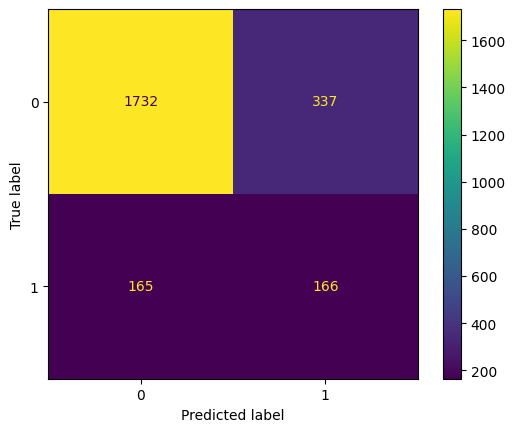

In [32]:
# run method to perfrom xgb workflow
model_name = "knn_df"
# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "None",  False)

all_results_df = model_results_df
all_grid_results_df  = grid_search_results_df


### 2.1.2 SVM performed With PCA 

<b> Perform PCA </b>

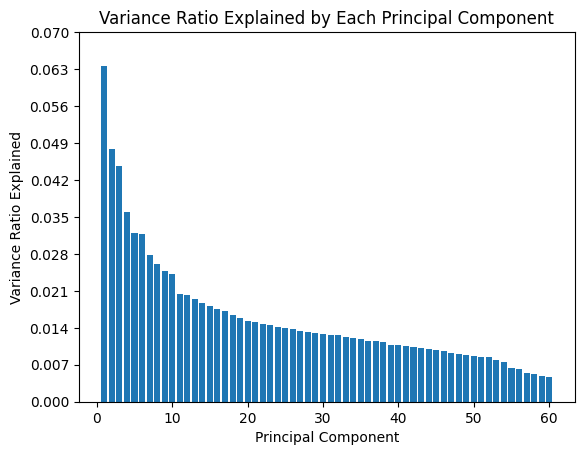

Number of components required to achieve 0.95 variance explained: 60


In [33]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train, X_test, categorical_features, 0.95)

Scaled samples:
(9600, 63) (9600,)
Outside if Scaled samples:
(2400, 63) (9600,)
Resampling samples:
(9600, 66) (9600,)
Resampling samples:
(9600, 66) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2069
           1       0.33      0.59      0.42       331

    accuracy                           0.78      2400
   macro avg       0.63      0.70      0.64      2400
weighted avg       0.84      0.78      0.80      2400



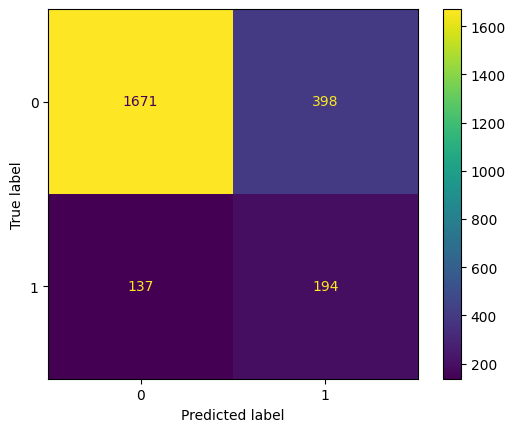

In [34]:
# run method to perfrom xgb workflow
model_name = "PCA_knn_df"
# call method
# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train_PCA, y_train, X_test_PCA, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "None",  True)

all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)


### 2.1.3 SVM performed With SMOTE

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2069
           1       0.48      0.27      0.35       331

    accuracy                           0.86      2400
   macro avg       0.68      0.61      0.63      2400
weighted avg       0.83      0.86      0.84      2400



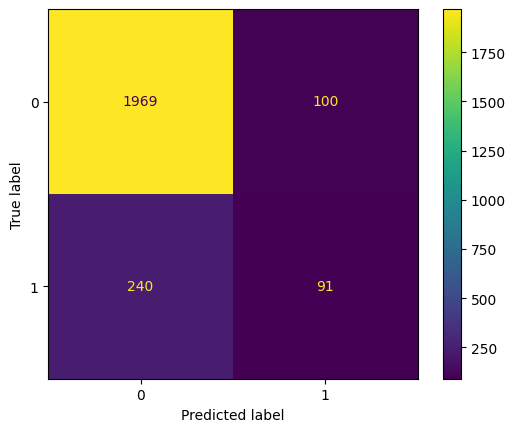

In [35]:
model_name = "SMOTE_knn_df"

# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "SMOTE",  False)

all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 2.1.4 SVM performed With Random Oversampling

Scaled samples:
(9600, 80) (9600,)


Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2069
           1       0.48      0.26      0.34       331

    accuracy                           0.86      2400
   macro avg       0.68      0.61      0.63      2400
weighted avg       0.83      0.86      0.84      2400



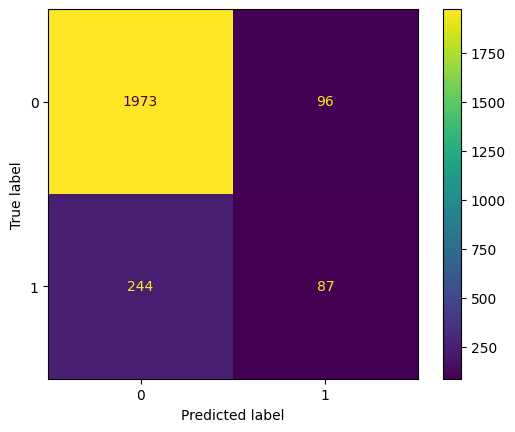

In [36]:
model_name = "ROS_knn_df"
# call method

# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "Oversampling",  False)

all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 2.1.5 SVM performed With Random Undersampling

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      2069
           1       0.27      0.66      0.38       331

    accuracy                           0.71      2400
   macro avg       0.60      0.69      0.60      2400
weighted avg       0.84      0.71      0.75      2400



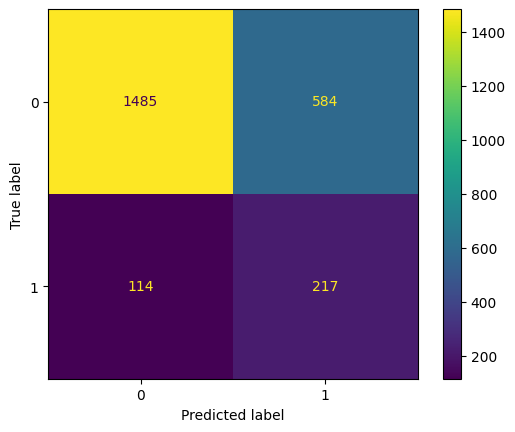

In [37]:
model_name = "RUS_knn_df"
# call method

# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "Undersampling",  False)

all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

###############################################

### 3.1 Using -1 inputed NAN file

In [38]:
#loading dataframe
minus1_df = pd.read_csv(os.path.join(file_path_to_save, 'minus1_imputed_df.csv')) 

In [39]:
pd.options.display.max_columns = None
minus1_df.sample()


,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
10797,159908.0,37.0,0,4,37.304687,1,24.0,4.166667,0.141238,1.1,0.0,0.5,0.5,0.0,11.0,0.0,80.5,98.0,121.0,17.346939,-1.235354,22.0,4.545455,26.9,6.69145,76.0,92.0,7.894737,-0.378053,3.5,3.6,3.8,2.777778,3.0,11.666667,1.75,1.7,1.8,5.882353,79.25,116.0,5.362776,82.0,-0.042419,142.0,1.408451,0.170148,81.67,82.67,1.22444,82.67,2.0,35.0,36.0,2.857143,0.001862,125.5,133.0,190.0,11.278195,-1.700503,7.39,0.811908,103.0,7.76699,1.009679,37.1,37.8,0.808625,36.6,55.0,140.0,45.454545,70.0,-0.038993,12.4,4.032258,-0.038258,95.5,0.0,0.129866,28,0


In [40]:
minus1_df.shape


(12000, 83)

In [41]:
# Convert the specified columns to categorical type
minus1_df[categorical_features] = minus1_df[categorical_features].astype("category")


<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [42]:
# Extract features and target variable
X = knn_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])  # Drop the target variable and 'Length_of_stay' column
y = knn_df['In-hospital_death']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size= test_size,
        random_state = RANDOM_STATE
    )

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9600, 80)
X_test shape: (2400, 80)
y_train shape: (9600,)
y_test shape: (2400,)


### 3.1.1 SVM performed Without PCA 

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2069
           1       0.33      0.50      0.40       331

    accuracy                           0.79      2400
   macro avg       0.62      0.67      0.64      2400
weighted avg       0.83      0.79      0.81      2400



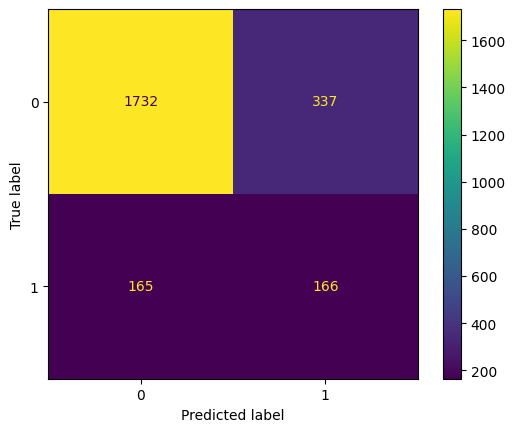

In [43]:
# run method to perfrom xgb workflow
model_name = "m1_df"
# call method

# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "None",  False)

all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.2 SVM performed With PCA 

<b> Perform PCA </b>

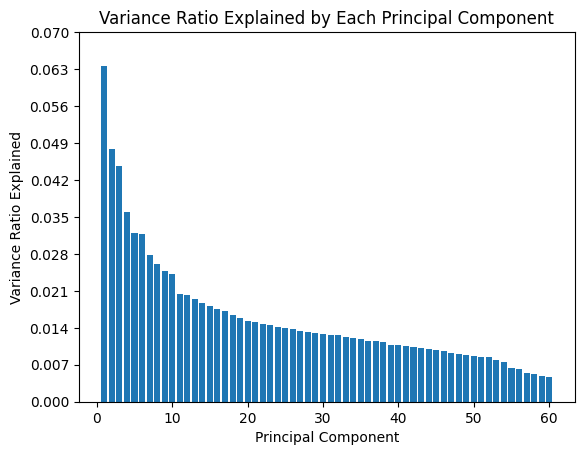

Number of components required to achieve 0.95 variance explained: 60


In [44]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train, X_test, categorical_features, 0.95)

Scaled samples:
(9600, 63) (9600,)
Outside if Scaled samples:
(2400, 63) (9600,)
Resampling samples:
(9600, 66) (9600,)
Resampling samples:
(9600, 66) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2069
           1       0.33      0.59      0.42       331

    accuracy                           0.78      2400
   macro avg       0.63      0.70      0.64      2400
weighted avg       0.84      0.78      0.80      2400



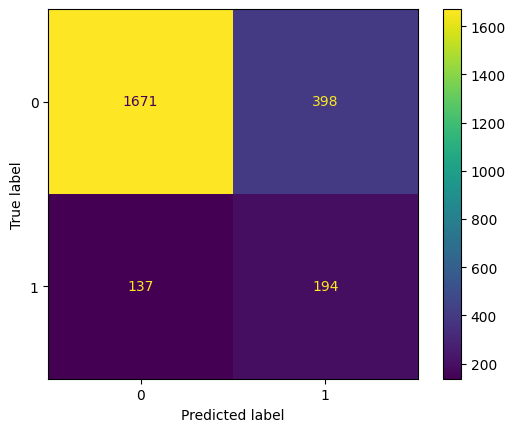

In [45]:
# run method to perfrom xgb workflow
model_name = "PCA_m1_df"
# call method
# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train_PCA, y_train, X_test_PCA, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "None",  True)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.3 SVM performed With SMOTE

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2069
           1       0.48      0.27      0.35       331

    accuracy                           0.86      2400
   macro avg       0.68      0.61      0.63      2400
weighted avg       0.83      0.86      0.84      2400



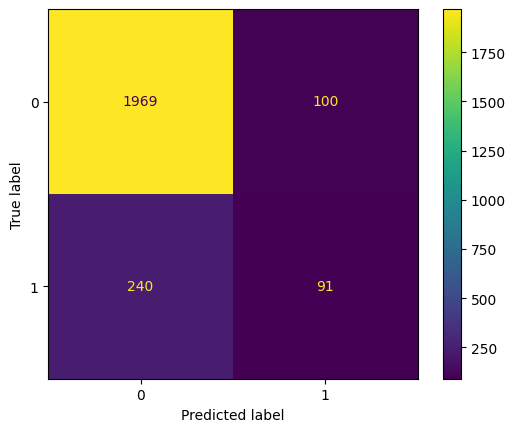

In [46]:
model_name = "SMOTE_m1_df"
# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "SMOTE",  False)
# call method
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.4 SVM performed With RamdonOversampling

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2069
           1       0.48      0.26      0.34       331

    accuracy                           0.86      2400
   macro avg       0.68      0.61      0.63      2400
weighted avg       0.83      0.86      0.84      2400



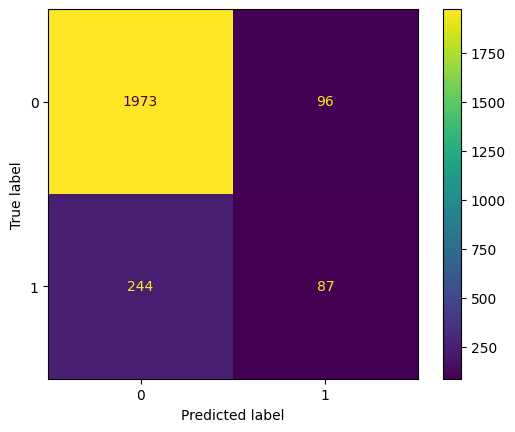

In [47]:
model_name = "ROS_m1_df"
#call method
# Call the perform_full_svm_workflow function
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "Oversampling",  False)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.5 SVM performed With RamdonUndersampling

Scaled samples:
(9600, 80) (9600,)
Outside if Scaled samples:
(2400, 80) (9600,)
Resampling samples:
(9600, 83) (9600,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      2069
           1       0.32      0.66      0.44       331

    accuracy                           0.76      2400
   macro avg       0.63      0.72      0.64      2400
weighted avg       0.85      0.76      0.79      2400



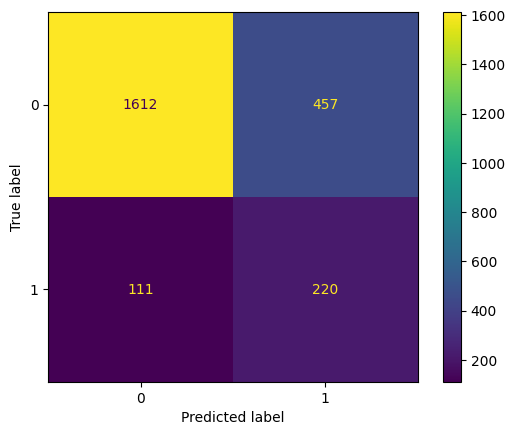

In [48]:
model_name = "RUS_m1_df"
# call method
best_svm_classifier, grid_search_results_df, model_results_df = perform_full_svm_workflow(X_train, y_train, X_test, y_test, one_hot_encoding_categorical_features, categorical_features, svm_param_grid, fone_scorer, model_name, cross_validation_folds , "Undersampling",  False)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

## Evaluate models results

In [49]:
sorted_all_grid_results_df = all_grid_results_df.sort_values(by='Cvalidation_test_score', ascending=False)
sorted_all_grid_results_df = sorted_all_grid_results_df.sort_values(by=['Method', 'Cvalidation_test_score'], ascending=[True, False])
sorted_all_grid_results_df

,Model,Method,params,Cvalidation_test_score,std_validation_score,kernel,degree,class_weight,C,gamma
24,SVM,PCA_knn_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.412432,0.026416,poly,2,balanced,25,scale
25,SVM,PCA_knn_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.378651,0.018987,poly,3,balanced,25,scale
26,SVM,PCA_knn_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.342639,0.012996,poly,4,balanced,25,scale
9,SVM,PCA_m1_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.399170,0.033489,poly,2,balanced,25,scale
10,SVM,PCA_m1_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.376723,0.010895,poly,3,balanced,25,scale
11,SVM,PCA_m1_df,"{'C': 25, 'class_weight': 'balanced', 'degree'...",0.341738,0.026096,poly,4,balanced,25,scale
20,SVM,ROS_knn_df,"{'C': 25, 'class_weight': None, 'degree': 4, '...",0.962795,0.002578,poly,4,None,25,scale
19,SVM,ROS_knn_df,"{'C': 25, 'class_weight': None, 'degree': 3, '...",0.956122,0.001609,poly,3,None,25,scale
18,SVM,ROS_knn_df,"{'C': 25, 'class_weight': None, 'degree': 2, '...",0.909731,0.004522,poly,2,None,25,scale
5,SVM,ROS_m1_df,"{'C': 25, 'class_weight': None, 'degree': 4, '...",0.962773,0.004130,poly,4,None,25,scale


In [50]:
#Final model results sorted by the minimum between precision and recall
# Compute the minimum value between Precision and Recall
all_results_df['Min_Precision_Recall'] = all_results_df[['Precision', 'Recall']].min(axis=1)

# Sort the DataFrame by the 'Min_Precision_Recall' column in descending order
sorted_results_df = all_results_df.sort_values(by='Min_Precision_Recall', ascending=False)


sorted_results_df

,Model,Method,Precision,Recall,F1-Score,Min_Precision_Recall
4,SVM,m1_df,0.330020,0.501511,0.398082,0.330020
9,SVM,knn_df,0.330020,0.501511,0.398082,0.330020
3,SVM,PCA_m1_df,0.327703,0.586103,0.420368,0.327703
8,SVM,PCA_knn_df,0.327703,0.586103,0.420368,0.327703
0,SVM,RUS_m1_df,0.324963,0.664653,0.436508,0.324963
2,SVM,SMOTE_m1_df,0.476440,0.274924,0.348659,0.274924
7,SVM,SMOTE_knn_df,0.476440,0.274924,0.348659,0.274924
5,SVM,RUS_knn_df,0.270911,0.655589,0.383392,0.270911
1,SVM,ROS_m1_df,0.475410,0.262840,0.338521,0.262840
6,SVM,ROS_knn_df,0.475410,0.262840,0.338521,0.262840
